# Regularisierung auf dem Titanic-Datensatz

Hinweis: Da das Notebook nur das Prinizip der Regularisierung zeigen soll, ist der ML-Worflow in diesem Notebook stark vereinfacht (d.h. kein Auffüllen von N/As, kein Feature-Scaling und keine kategorischen Features).

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pd.options.mode.chained_assignment = None  # avoid slide-copy-warning 

In [71]:
df = pd.read_csv("data/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
df_selection = df[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]]
df_selection = df_selection.dropna()
df_selection.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [73]:
df_X = df_selection.drop(columns = ["Survived"])
df_y = df_selection["Survived"]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)

## Aufgaben:

### Aufgabe 1: Ridge-Regularisierung
1. Trainieren Sie eine Logistische Regression mit Ridge-Regularisierung (siehe [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)) mit $\alpha =100$ auf den Trainingsdaten.
2. Bestimmen Sie die Accuracy auf den Testdaten.

In [74]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier(alpha=100)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
accuracy_score(y_test, y_pred)


0.6713286713286714

### Aufgabe 2: Cross-Validation über $\alpha$
1. Führen Sie nun eine Cross-Validation mit Hilfe der Klasse [RidgeClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html) durch. Benutzen Sie dafür die gleichen Werte für $\alpha$ wie im Notebook [`4_OverUnderfitting.ipynb`](4_OverUnderfitting.ipynb) in Zelle 9.
2. Bestimmen Sie die Accuracy auf den Testdaten.

In [75]:
from sklearn.linear_model import RidgeClassifierCV

alphas = list(range(1, 10000))

ridge_cv = RidgeClassifierCV(alphas=alphas)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.alpha_)

y_pred = ridge_cv.predict(X_test)
print(accuracy_score(y_test, y_pred))

6
0.6853146853146853


### Aufgabe 3:  Lasso-Regularisierung
Für die Lasso-Regularisierung gibt es keine extra Unterklasse, da diese bei der Klasse `LogisitcRegression` über den Parameter `penalty` eingestellt werden kann. Mit dem Parameter `penalty = "l1"` wird die Lasso-Regression verwendet.
Der Regularisierungsfaktor $\alpha$ wird in diesem Fall über den Parameter `C` bestimmt, welcher den Default-Wert `C=1.0` hat:

`LogisticRegression(max_iter=1000, penalty = "l1", C=1.0, solver="liblinear")`

Beachten Sie dabei:
- Für die Regression ist das zusätzliche Argument `solver="liblinear"` nötig, da der Standard-Optimierer nicht mit `L1` funktioniert.
- Parameter `C` gibt die <ins>inverse</ins> Stärke der Regularisierung an (Details siehe [hier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).


1. Trainieren Sie eine Logistische Regression mit Lasso-Regression für verschiedene Parameter `C`:
    - den Default-Wert `C=1.0`.
    - wählen Sie `C` so, dass das Modell sehr stark regularisiert ist.
    - wählen Sie `C` so, dass das Modell keine Regularisierung hat.
2. Vergleiche Sie die Ergebnisse dieser Modelle indem Sie:
    - die Gewichte und deren Summe ausgeben (wie im Notebook [`4_OverUnderfitting.ipynb`](4_OverUnderfitting.ipynb)).
    - die Accuracy auf den Testdaten ermitteln. 

MSE: 0.3076923076923077
Accuracy: 0.6923076923076923


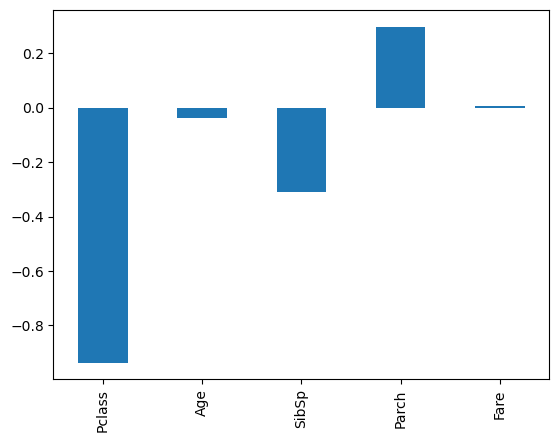

In [76]:
from sklearn.metrics import mean_squared_error


def predict(n):
    reg = LogisticRegression(max_iter=1000, penalty= "l1", C=n, solver="liblinear")
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE: {mse}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    pd.Series(reg.coef_[0], index = df_X.columns).plot(kind='bar')
predict(1)

MSE: 0.3356643356643357
Accuracy: 0.6643356643356644


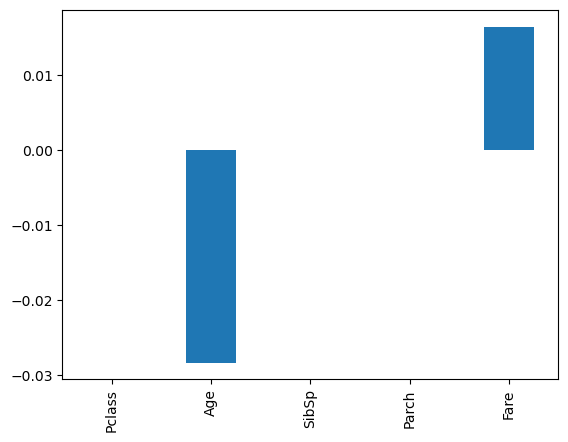

In [77]:
predict(0.01)

MSE: 0.3146853146853147
Accuracy: 0.6853146853146853


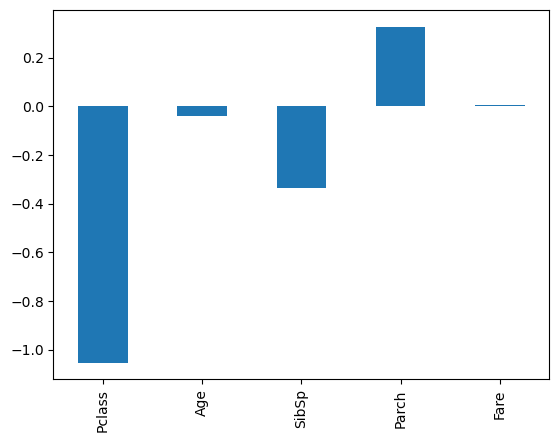

In [78]:
predict(1000)

### Aufgabe 4. Cross-Validierung über  `C`
Ein guter Wert für `C` soll nun mit Hilfe der Methode `cross_val_score` gefunden werden. Ein Beispiel für diese Methode ist:

In [82]:
from sklearn.model_selection import cross_val_score

model = LogisticRegression(max_iter=1000, penalty = "l1", C=1.0, solver="liblinear")
cvs = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")

Die Methode führt eine k-fold Cross-Validation auf den Trainingsdaten durch und gibt für jeden der k-folds den Score (in diesem Fall "accuracy") des Modell auf den jeweiligen Validierungsdaten zurück.

1. Berechnen Sie den Durchschnitt der Rückgabewerte von `cross_val_score` um für das gegebene `model` den durchschnittlichen Accuarcy-Score über alle k-folds zu erhalten.
2. Berechnen Sie für jeden der Werte $ C \in [0.1, 0.2, ...,9.8, 9.9]$ den durchschnittlichen Accuarcy-Score.
3. Trainieren Sie das Modell mit dem besten Wert für $C$ auf allen Trainingsdaten.
4. Bestimmen Sie die Accuracy dieses Modells auf den Testdaten.

In [87]:
#dictonary with c and average cross validation score
cvs_dict = {}

for i in np.arange(0.1, 10, 0.1):
    model = LogisticRegression(max_iter=1000, penalty = "l1", C=i, solver="liblinear")
    cvs = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    avr_cvs = np.mean(cvs)
    print(f"Average Cross Validation Score for C={i}: {avr_cvs}")
    cvs_dict[i] = avr_cvs

best_c = max(cvs_dict, key=cvs_dict.get)

print(f"Best C: {best_c}")

model = LogisticRegression(max_iter=1000, penalty = "l1", C=best_c, solver="liblinear")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Average Cross Validation Score for C=0.1: 0.6953012967200609
Average Cross Validation Score for C=0.2: 0.7041189931350115
Average Cross Validation Score for C=0.30000000000000004: 0.7216475972540046
Average Cross Validation Score for C=0.4: 0.7128756674294433
Average Cross Validation Score for C=0.5: 0.7093668954996186
Average Cross Validation Score for C=0.6: 0.7058733790999238
Average Cross Validation Score for C=0.7000000000000001: 0.7041189931350115
Average Cross Validation Score for C=0.8: 0.7023646071700992
Average Cross Validation Score for C=0.9: 0.7023646071700992
Average Cross Validation Score for C=1.0: 0.6988558352402746
Average Cross Validation Score for C=1.1: 0.7006102212051869
Average Cross Validation Score for C=1.2000000000000002: 0.7006102212051869
Average Cross Validation Score for C=1.3000000000000003: 0.6988558352402746
Average Cross Validation Score for C=1.4000000000000001: 0.6988558352402746
Average Cross Validation Score for C=1.5000000000000002: 0.70059496567